In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# IMPORTING THE DATASET
d = pd.read_csv('m500_lap_time_rank_ver5.csv')
df = pd.DataFrame(data=d)

# FOR ROWS 4267 TO THE END, THERE IS ADDITIONAL DATA FOR SPECIFIC ATHLETES. BECAUSE IT UNCLEAR AS TO WHICH RACES
# THESE DATA POINTS BELONG TO AND WHETHER THE FULL INFORMATION FOR THESE RACES HAVE BEEN INCLUDED, THIS PART OF 
# THE DATA WILL BE OMMITTED FROM THE PAPER
N = 5125 - 4267
df = df.iloc[:-N , :]
df

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,time_lap1,rank_lap2,time_lap2,rank_lap3,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.52,1.0,9.22,1.0,8.76,1.0,8.87,1.0,9.09,2013.046575
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.44,2.0,9.31,2.0,8.89,2.0,8.88,2.0,9.27,2013.046575
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.64,3.0,9.74,3.0,9.04,3.0,9.05,3.0,9.21,2013.046575
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.46,4.0,9.93,4.0,9.50,4.0,9.67,4.0,9.91,2013.046575
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,7.08,2.0,9.18,2.0,8.76,2.0,8.86,1.0,8.90,2013.046575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,7.15,5.0,8.82,3.0,8.30,4.0,8.45,4.0,8.76,2016.113470
4263,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,6.94,3.0,8.83,5.0,18.89,5.0,13.46,5.0,15.48,2016.113470
4264,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,7.09,4.0,8.71,6.0,41.81,6.0,28.73,NaN,NaN,2016.113470
4265,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalB,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.113470


In [28]:
# CLEANING THE DATA: CERTAIN RACES WILL BE REMOVED TO GET A MORE REPRESENTATIVE DATASET:


# 1) Races where there were penalties and/or did not start/finish outcomes: 
# the data point of the athlete with this outcome is removed, the race itself will be removed at (3)
for index, row in df.iterrows():
    if (row['Qualification'] == "PEN" or row['Qualification'] == "DNF" or row['Qualification'] == "DNS"):
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)


# 2) Races with missing data
for index, row in df.iterrows():
    if (np.isnan(row['rank_lap1']) or np.isnan(row['rank_lap2']) or np.isnan(row['rank_lap3']) or np.isnan(row['rank_lap4']) or np.isnan(row['rank_lap5'])): 
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)


# 3) Races where there were < or > 4 skaters: 
# a "race label" is assigned to each skater to determine which race they participated in and races whose labels are 
# counted more or less than 4 times are removed from the dataset
for index, row in df.iterrows():
    if (row['rank_lap5']==0.0 or row['rank_lap1']==5.0 or row['rank_lap2']==5.0 or row['rank_lap3']==5.0 or row['rank_lap4']==5.0 or row['rank_lap5']==5.0):
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)

arr = [None]*df['City'].count()
label = 0
for index, row in df.iterrows():
    if (row['Rank_In_Group'] == 1):
        label=label+1
        arr[index] = label
    else:
        arr[index] = label
        
df['Race_label'] = arr

value_counts = df['Race_label'].value_counts()
to_remove = value_counts[value_counts != 4].index
df = df[~df.Race_label.isin(to_remove)]
df = df.reset_index(drop=True)

df
# After this process, we are left with 2552 data points (638 races) 

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,rank_lap2,time_lap2,rank_lap3,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event,Race_label
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,1.0,9.22,1.0,8.76,1.0,8.87,1.0,9.09,2013.046575,1
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,2.0,9.31,2.0,8.89,2.0,8.88,2.0,9.27,2013.046575,1
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,3.0,9.74,3.0,9.04,3.0,9.05,3.0,9.21,2013.046575,1
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,4.0,9.93,4.0,9.50,4.0,9.67,4.0,9.91,2013.046575,1
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,2.0,9.18,2.0,8.76,2.0,8.86,1.0,8.90,2013.046575,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,RepSemifinals,2,...,4.0,9.11,4.0,8.35,4.0,8.65,4.0,9.29,2016.113470,980
2548,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,1.0,8.91,1.0,8.43,1.0,8.55,1.0,8.83,2016.113470,984
2549,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,3.0,8.88,2.0,8.33,2.0,8.57,2.0,8.81,2016.113470,984
2550,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,2.0,8.95,3.0,8.43,3.0,8.59,3.0,8.85,2016.113470,984


In [29]:
# PREPARING THE VARIABLES FOR THE LOGISTIC REGRESSION:
# The predictor variable will be the combination of intermediate rankings (categorical variable)
# The response variable will be the skater's rank in the 5th(last) lap (also represents his final rank for the race)

    
# CATEGORICAL PREDICTOR VARIABLE
# Combinations of intermediate rankings (value format: <rank in lap 1><rank in lap 2><rank in lap 3><rank in lap 4>)
interRanksLabel = [None]*df['City'].count()
for index, row in df.iterrows():  
    interRanksLabel[index] = str(int(row["rank_lap1"])) + str(int(row["rank_lap2"])) + str(int(row["rank_lap3"])) + str(int(row["rank_lap4"]))
df['interRanksLabel'] = interRanksLabel

# We end up with 89 different values for the categorical variable. To avoid overfitting the model, we remove values
# with occurences < 10
value_counts = df['interRanksLabel'].value_counts()
to_remove = value_counts[value_counts < 10].index
df = df[~df.interRanksLabel.isin(to_remove)]
df = df.reset_index(drop=True)

# Encoding the categorical values:
# We will use label encoding to encode the categorical values for logistic regression
df["interRanksLabel"] = df["interRanksLabel"].astype('category')
df["Categorical_label_code"] = df["interRanksLabel"].cat.codes


# RESPONSE VARIABLE
# The rankings for the last lap:
    # 0 if the skater did not finish the race in 1st place 
    # 1 if the skater finished the race in 1st place 
interRespLabel = [None]*df['City'].count()
for index, row in df.iterrows(): 
    if (row["rank_lap5"] != 1):
        interRespLabel[index] = 0
    else:
        interRespLabel[index] = 1
df["Response_Level"] = interRespLabel
df        

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event,Race_label,interRanksLabel,Categorical_label_code,Response_Level
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,8.89,2.0,8.88,2.0,9.27,2013.046575,1,1222,4,0
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,9.04,3.0,9.05,3.0,9.21,2013.046575,1,4333,23,0
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.76,2.0,8.86,1.0,8.90,2013.046575,2,2222,8,1
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.77,1.0,8.86,2.0,9.01,2013.046575,2,1111,0,0
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.94,3.0,9.05,3.0,9.12,2013.046575,2,4333,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,RepSemifinals,2,...,8.35,4.0,8.65,4.0,9.29,2016.113470,980,4444,27,0
2359,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.43,1.0,8.55,1.0,8.83,2016.113470,984,1111,0,1
2360,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.33,2.0,8.57,2.0,8.81,2016.113470,984,3322,16,0
2361,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.43,3.0,8.59,3.0,8.85,2016.113470,984,2233,11,0


In [58]:
# APPLYING THE LOGISTIC REGRESSION MODEL

cols = ['Categorical_label_code', 'rank_lap1', 'rank_lap2', 'rank_lap3', 'rank_lap4']
X=df[cols]
y=df.Response_Level
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.213115
         Iterations 9
                            Results: Logit
Model:                 Logit              Pseudo R-squared:   0.624    
Dependent Variable:    Response_Level     AIC:                1017.1794
Date:                  2021-11-27 15:52   BIC:                1046.0179
No. Observations:      2363               Log-Likelihood:     -503.59  
Df Model:              4                  LL-Null:            -1341.0  
Df Residuals:          2358               LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        9.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Categorical_label_code -0.5944   0.0286 -20.8108 0.0000 -0.6504

In [85]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [102]:
y_pred = logreg.predict(X_test)

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       441
           1       0.85      0.90      0.88       150

    accuracy                           0.94       591
   macro avg       0.91      0.92      0.92       591
weighted avg       0.94      0.94      0.94       591



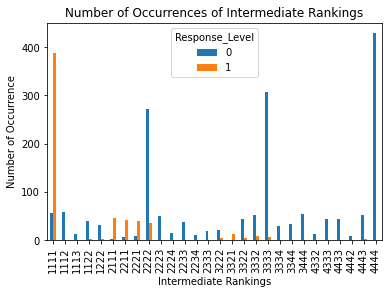

In [82]:
%matplotlib inline
pd.crosstab(df['interRanksLabel'],y).plot(kind='bar')
plt.xlabel('Intermediate Rankings')
plt.ylabel('Number of Occurrence')
plt.title('Number of Occurrences of Intermediate Rankings')
plt.savefig('num_interRanks')
plt.show()

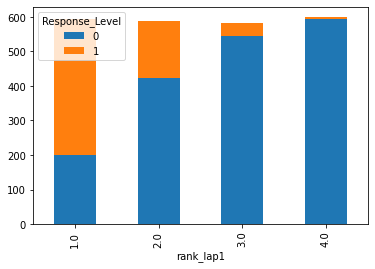

In [62]:
%matplotlib inline
pd.crosstab(df['rank_lap1'],y).plot(kind='bar', stacked=True)
plt.show()

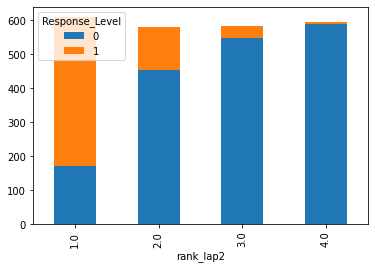

In [63]:
%matplotlib inline
pd.crosstab(df['rank_lap2'],y).plot(kind='bar', stacked=True)
plt.show()

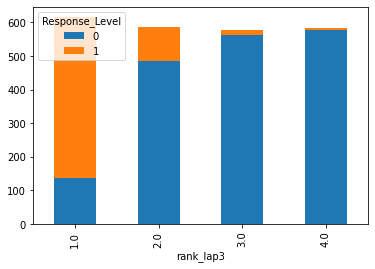

In [84]:
%matplotlib inline
pd.crosstab(df['rank_lap3'],y).plot(kind='bar', stacked=True)
plt.show()

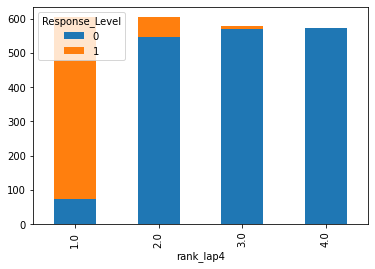

In [65]:
%matplotlib inline
pd.crosstab(df['rank_lap4'],y).plot(kind='bar', stacked=True)
plt.show()

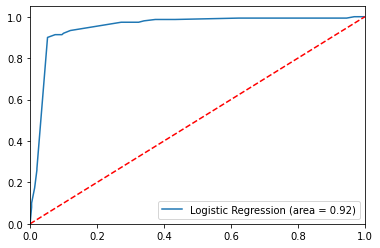

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [97]:
df['time_lap4'].std()

1.9457512098731955

In [81]:
df['interRanksLabel'].value_counts()

1111    445
4444    430
3333    314
2222    308
3332     61
1112     59
4443     55
3444     55
2223     50
2111     50
3322     50
2211     49
2221     48
4333     46
4433     44
1122     42
2233     37
1222     34
3344     34
3334     29
3222     26
2333     20
2224     15
4332     15
3321     13
1113     13
2234     11
4442     10
Name: interRanksLabel, dtype: int64